# Symmetrical choiceset:

We want to symmetrically sample both sides of the subjective equality point. 
That means having equal amount of trials in each side of the SV difference. 

This version of the code doesn't use python external libraries. The reason is to optimize the code to make it compatible with online based tasks that use Js. 

JS script data types we are going to use:
- Arrays: written with square brackets. Items are separated by commas. This is analogous to python lists. 

    ``` const cars = ["Saab", "Volvo", "BMW"]; ```
- Objects: JavaScript objects are written with curly braces {}.

Object properties are written as name:value pairs, separated by commas.

This is analogous to python dictionaries. I intend to use them to create the desired choicet. 

        const person = {firstName:"John", lastName:"Doe",  age:50, eyeColor:"blue"}

We use zip throughout. Looks like we can do something similar in Javascript

https://stackoverflow.com/questions/4856717/javascript-equivalent-of-pythons-zip-function

`zip= rows=>rows[0].map((_,c)=>rows.map(row=>row[c]))`

In [1]:
import math
import csv #This is the only library I will use. However, it is built in python. 
post_mean_gain = [0.45456, 1.0343]
post_mean_loss = [0.896596, -0.765]


The idea is to create an output CSV without using pandas :(
    We are going to do this by using lists and dicitonaries. The idea is to creaate the trials as lists of dictionries

With that, we can create the CSV at the end
```
Trials = 
{'category': ['Zero_Reward',  'Zero_Reward',..., 'Int_neg', 'Int_neg','Int_neg'],
 'p_reward': [0.75, 0.5,0.38, 0.25, 0.13, ..., 0.75 0.5, 0.38,0.25,0.13],
 'value_reward': [-0.0,  -5.71, ..., -22.453 , -34.884],
 'ambiguity': [0.0, 0.0,0.0  0.24, 0.5, 0.74, 0.0, 0.0],
 'SV_reward': [0.0, -5.551115123125783e-17, -1.813, -3.62, -2.222, -4.532],
 'SV_New_Safe': [-2.719, -1.8130],
 'value_lott_SE': [-12.723, -12.723, -12.72,
  'value_safe': [-7.20, -0.226,  -2.995, -2.7-2.51]
 }
```

# 1. Input: ADO parameters

In [2]:
alpha_pos, beta_pos = post_mean_gain[0], post_mean_gain[1] #parameters for gains
alpha_neg, beta_neg = post_mean_loss[0], post_mean_loss[1] #parameters for losses

### Parameters varaibles needed

In [3]:
#Declare the variables
p_options = [0.75, 0.5, 0.38, 0.25, 0.13]
amb_options = [0.24, 0.5, 0.74]
A_null = 0.0 # no ambiguity
Vmax = 50.0 #The maximum amount we can pay to participants
Vmin = -50.0 #The minimum amount we can take from participants
# Vsafe_pos = 5.0 # The old safe option in positive trials
# Vsafe_neg = -5.0 # The old safe option in negative trials

#First, we create an empty dictionary that we will populate with the trials info. 

empty_trials = { #An indivual trial consists of the values with the same index in the different lists
  'category': [],
  'p_reward': [],
  'ambiguity': [],
  'value_reward': [],
  'SV_reward': [],
  'value_safe': [],
  'SV_safe': []
}
# used to organize the dictionary by keys
ordered_keys = empty_trials.keys()

### useful functions

In [4]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def order_keys(dict,keys):
    return {k: dict[k] for k in keys if k in dict.keys()}

def round_number(number):
    number_to_50 = round(number*2) / 2
    if number_to_50 == 0:
        return 0.50
    else:
        return number_to_50
    
def round_to_50(dict):
    cols = ['value_safe','value_reward']
    for c in cols:
        dict[c] = [round_number(v) for v in dict[c]]
    return dict


### CRDM functions defined 

functions are called below to create three portions: extreme, centered subjective equality, intermediate

In [5]:
##FUNCTIONS

#Create the extreme positive gains and losses
def get_extr_rows(p_options, domain='gain'):
    """
    Inputs:
        - p_options = list of probability values (float)
    Output:
        - dictionaries of lists containing the maximum gain or loss. With empty keys that we will populate later on with SV and Vsafw
    """
    extr = empty_trials.copy()
    category = 'Extr_pos' if domain == 'gain' else 'Extr_neg'
    V=[Vmax] * len(p_options) #A list of values with the same length as our p_options
    if domain == 'loss':
            V = [Vmin] * len(p_options)
    extr = {
            'category': [category]*len(p_options),
            'p_reward': p_options,
            'ambiguity': [0.0]*len(p_options),
            'value_reward': V,
        }
    return extr

#Add ambiguity
def add_ambig(trials,amb_options):
    """
    Inputs:
        - trials dictionary
        - amb_options = list of possible ambiguity values
    Output:
        - initial trials dictionary with new ambiguity trials
    """
    prob_amb=0.50
    V = [trials['value_reward'][0]]*len(amb_options)
    amb_trials = {
            'p_reward': [prob_amb]*len(amb_options),
            'value_reward': V,
            'ambiguity': [a for a in amb_options],
        }
    final_dict = {k: trials[k] + amb_trials[k] for k in set(trials) & set(amb_trials)}
    final_dict['category'] = [trials['category'][0]]*len(final_dict['value_reward'][:])
    return final_dict

#Add Subjective value given participant's alpha and beta
def add_SV(trials, alpha, beta, domain='gain'):
    """
    Inputs:
        - trials dictionary
        - Model parameters
    Output:
        - trials dictionary with subjective value 
    """
    Amp = 1.0
    if domain == 'loss':
          Amp = -1.0
    trials['SV_reward'] = [(p -(beta*A/2)) * (Amp*abs(v) ** alpha) for p, v, A 
                         in zip(trials['p_reward'], trials['value_reward'], trials['ambiguity'])] #This ZIP method is going to be a PIA in JS. However, I think we can emulate it in JS from scratch 
    return trials  

# Add Vsafe and its subjective value     
def add_Vsafe(trials, alpha,beta, domain = 'gain'):
    """
     This function creates appends the new values of safe options to the Extreme reward or loss dictionary. The subjective value of the safe is half of that 
     of the maximum gain or loss SVnew_safe = 0.5*SV_max for each probability.
     Inputs:
        - trials dictionary
        - Model parameters
    Output:
        - Appeneded New safe options to extreme trials
        - SV of SE trials
    """ 
    Amp = 1.0 
    if domain == 'loss':
        Amp = -1.0
    trials['SV_safe'] = [sv/2 for sv in trials['SV_reward']]
    trials['value_safe'] = [Amp*(abs(sv))**(1/alpha) for sv in trials['SV_safe']]
    return trials

def get_safe_trials (extr, alpha, beta, domain = 'gain'):
    """
    This function creates new values of safe options whose subjective value is half of that 
    of the maximum gain or loss SVnew_safe = 0.5*SV_max for each probability. That SV is going to be the SV of subjective equality 

    Inputs:
        - Extreme trials dictionary
        - Model parameters
    Output:
        - New safe options
        - SV of SE trials
    """
    safe_options = {}
    Amp = 1.0 
    if domain == 'loss':
        Amp = -1.0
    safe_options['p_reward'] = [p for p in extr['p_reward']]
    safe_options['ambiguity'] = [a for a in extr['ambiguity']]
    safe_options['SV_safe'] = [sv/2 for sv in extr['SV_reward']]
    safe_options['value_safe'] = [Amp*(abs(sv))**(1/alpha) for sv in safe_options['SV_safe']]
    return safe_options 
     
def get_SE_trials (trials, alpha, beta, domain = 'gains'):
    '''     
     Creates trials around the point of subjective equality

     Inputs:
     -Max reward or loss trials
     -Model Parameters 
    '''
    SE_trials = {}
    SE_trials['category'] = ['SE_pos']*len(trials['SV_safe'])
    Amp = 1.0 
    if domain == 'loss':
        Amp = -1.0
        SE_trials['category'] = ['SE_neg']*len(trials['SV_safe'])    
    SE_trials['p_reward'] = trials['p_reward']
    SE_trials['ambiguity'] = trials['ambiguity']
    SE_trials['SV_reward'] = [sv/2 for sv in trials['SV_reward']]
    SE_trials['SV_safe'] = trials['SV_safe']
    SE_trials['value_safe'] = [Amp*(abs(sv))**(1/alpha) for sv in trials['SV_safe']]
    SE_trials['value_reward'] = [(Amp*(abs(sv)/((p) - (beta*A/2)))**(1/alpha)) for sv, p, A
                                  in zip(trials['SV_safe'], trials['p_reward'], trials['ambiguity'])]
    return SE_trials

def get_cent_SE_trials(SE_trials,  alpha, beta, domain = 'gain'):
    cent_SE= {}
    SE_keys = ['p_reward', 'ambiguity', 'value_safe', 'value_reward', 'SV_safe']
    SE = {key: SE_trials[key] for key in SE_keys}
    cent_SE_trial_plus2 = {key: SE_trials[key] for key in SE_keys}
    cent_SE_trial_plus2['value_reward'] = [value_reward + 2.0 for value_reward in cent_SE_trial_plus2['value_reward']]

    cent_SE_trial_minus2 = {key: SE_trials[key] for key in SE_keys}
    cent_SE_trial_minus2['value_reward'] = [value_reward - 2.0 for value_reward in cent_SE_trial_minus2['value_reward']]

    # Merge dictionaries while keeping values in lists
    cent_SE = SE.copy()  # Start with the SE dictionary

    # Update values in cent_SE with values from cent_SE_trial_plus2
    for key, value in cent_SE_trial_plus2.items():
        cent_SE[key] = cent_SE[key] + value

    for key, value in cent_SE_trial_minus2.items():
        cent_SE[key] = cent_SE[key] + value
    Amp = 1.0 
    if domain == 'loss':
        Amp = -1.0
    cent_SE['SV_reward'] = [ (p-beta*A/2)*Amp*abs(v)**alpha for (p,A,v) in zip(cent_SE['p_reward'],cent_SE['ambiguity'],cent_SE['value_reward'])]

    cent_SE['category'] = ['Cent_SE_pos']*len(cent_SE['value_reward']) 
    if domain == 'loss':
        cent_SE['category'] = ['Cent_SE_neg']*len(cent_SE['value_reward'])  
    return cent_SE

def get_interm_trials(rows_extr, alpha, beta,num_steps=2, domain='gain'):
    '''     
     Creates intermediate trials between subjective equality and extreme

     Inputs:
     -Max reward or loss trials
     -Model Parameters 
    '''    
    full_int = {}

    SV_step =  [(reward-safe)/(num_steps + 1) for (reward,safe) in zip(rows_extr['SV_reward'],rows_extr['SV_safe'])]
    list_x = [i for i in range(-num_steps-1,num_steps+1) if i != 0]
    list_dict = []
    for x in list_x:
        interm = {}
        Amp,category = 1.0,'Int_pos'
        if domain == 'loss':
            Amp,category = -1.0,'Int'
        if x == -num_steps-1:
            category = 'Zero_Reward'
        interm['category'] = [category]*len(rows_extr['category'])
        interm['p_reward'] = rows_extr['p_reward']
        interm['ambiguity'] = rows_extr['ambiguity']
        interm['SV_reward'] = [safe+x*step for (safe,step) in zip(rows_extr['SV_safe'],SV_step)]
        interm['value_safe'] = rows_extr['value_safe']
        interm['SV_safe'] = rows_extr['SV_safe']
        interm['value_reward'] = [(Amp*(abs(sv)/((p) - (beta*A/2)))**(1/alpha)) for sv, p, A
                                      in zip(interm['SV_reward'], interm['p_reward'], interm['ambiguity'])]
        list_dict += [interm]
    full_int = {k :flatten([d[k] for d in list_dict]) for k in list_dict[0]}
    return full_int


## Convert column names and make it look like CRDM choice set

In [6]:
# we can use Math.random
import numpy as np
def gen_random_list(len):
    return [round(np.random.rand()) for i in range(len)]

def pavlovia_dict(dict,domain='gain'):
    nb_trials = len(dict['value_safe'])
    column_order = ['crdm_sure_amt', 'crdm_sure_p', 'crdm_lott_top', 'crdm_lott_bot', 'crdm_lott_p', 
                    'crdm_amb_lev', 'crdm_domain', 'crdm_img', 'crdm_nonzero_side']

    crdm_trials = {}
    crdm_trials['crdm_sure_amt'] = dict['value_safe']
    crdm_trials['crdm_sure_p'] = [100] * nb_trials

    # assign randomly top or bottom
    random_list = gen_random_list(nb_trials)
    crdm_trials['crdm_lott_top'] = [v if loc==1 else 0 for v,loc in zip(dict['value_reward'],random_list)]
    crdm_trials['crdm_lott_bot'] = [v if loc==0 else 0 for v,loc in zip(dict['value_reward'],random_list)]
    crdm_trials['crdm_nonzero_side'] = ['top' if loc==1 else 'bottom' for v,loc in zip(dict['value_reward'],random_list)]
    
    crdm_trials['crdm_lott_p'] = [round(100*p) for p in dict['p_reward']]
    crdm_trials['crdm_amb_lev'] = [round(100*a) for a in dict['ambiguity']]
    
    crdm_img = []
    for p,a,side in zip(crdm_trials['crdm_lott_p'],crdm_trials['crdm_amb_lev'],crdm_trials['crdm_nonzero_side']):
        if a > 0:
            crdm_img += ['ambig_{}.bmp'.format(a)]
        elif side == 'top':
            crdm_img += ['risk_red_{}.bmp'.format(p)]
        elif side == 'bottom':
            crdm_img += ['risk_blue_{}.bmp'.format(p)]

    crdm_trials['crdm_img'] = crdm_img
    crdm_trials['crdm_domain'] = [domain]*nb_trials
    crdm_trials = order_keys(crdm_trials,column_order)
    return crdm_trials



### Calling the functions to make the three portions of the trials


In [7]:
def get_trials(p_options,amb_options,alpha,beta,ordered_keys=[],domain='gain',verbose=False):
    rows_extr = get_extr_rows(p_options, domain = domain)
    rows_extr = add_ambig(rows_extr,amb_options)
    rows_extr = add_SV(rows_extr, alpha,beta, domain = domain)
    rows_extr = add_Vsafe(rows_extr, alpha,beta,domain=domain)
    rows_extr = order_keys(rows_extr,ordered_keys)

    #Neg Safe options dictionary. is this necessary? 
    # safe_neg = get_safe_trials(rows_extr, alpha, beta, domain= domain)

    #Subjective equality trials SE_neg = get_SE_trials(rows_extr, alpha, beta, domain='loss')
    # cent contains SE_neg within it... SE_neg not needed later on
    cent = get_cent_SE_trials(get_SE_trials(rows_extr, alpha, beta, domain=domain), alpha, beta, domain = domain)
    cent = order_keys(cent,ordered_keys)

    interm = get_interm_trials(rows_extr, alpha, beta,domain=domain)
    interm = order_keys(interm,ordered_keys)
    if verbose:
        print(rows_extr)
        print(cent)
        print(interm)

    # Concat dictionaries into one
    trials_list = []
    trials_list.append(rows_extr)
    trials_list.append(interm)
    trials_list.append(cent)
    trials = {k :flatten([d[k] for d in trials_list]) for k in trials_list[0]}
    
    return round_to_50(trials)


### Output CSV

In [8]:
def get_element_by_col(my_dict,row_nb):
    row_dict=dict.fromkeys(my_dict.keys())
    for c in my_dict.keys():
        row_dict[c] = my_dict[c][row_nb]
    return row_dict

def convert_list_dict(my_dict):
    my_list_dict = []
    nb_trials = len(my_dict[next(iter(my_dict))])
    for row_nb in range(nb_trials):
        row_dict = dict.fromkeys(my_dict.keys())
        row_dict = get_element_by_col(my_dict,row_nb)
        my_list_dict += [row_dict]
    return my_list_dict

In [9]:
def save_to_csv(crdm_trials,fn='/tmp/out.csv'):
    crdm_trials_list = convert_list_dict(crdm_trials)
    
    print('Saving to : {}'.format(fn))
    # Open a file in write mode.
    with open(fn, 'w') as f:
        # Write all the dictionary keys in a file with commas separated.
        f.write(','.join(crdm_trials_list[0].keys()))
        f.write('\n') # Add a new line
        for row in crdm_trials_list:
            # Write the values in a row.
            f.write(','.join(str(x) for x in row.values()))
            f.write('\n') # Add a new line


# void_main() style part of the script

In [10]:
# round value_reward and vallue_safe to nearest 50 cents
trials_gain = get_trials(p_options,amb_options,alpha_pos,beta_pos,ordered_keys=ordered_keys,domain='gain',verbose=False)
trials_loss = get_trials(p_options,amb_options,alpha_neg,beta_neg,ordered_keys=ordered_keys,domain='loss',verbose=False)

crdm_trials_gain = pavlovia_dict(trials_gain,domain='gain')
crdm_trials_loss = pavlovia_dict(trials_loss,domain='loss')
crdm_trials = {k :flatten([d[k] for d in [crdm_trials_gain,crdm_trials_loss]]) for k in crdm_trials_gain}

fn = 'csv/crdm_trials_online.csv'
save_to_csv(crdm_trials,fn = fn)


Saving to : csv/crdm_trials_online.csv


## (Visualization) Just for checking Mandy!

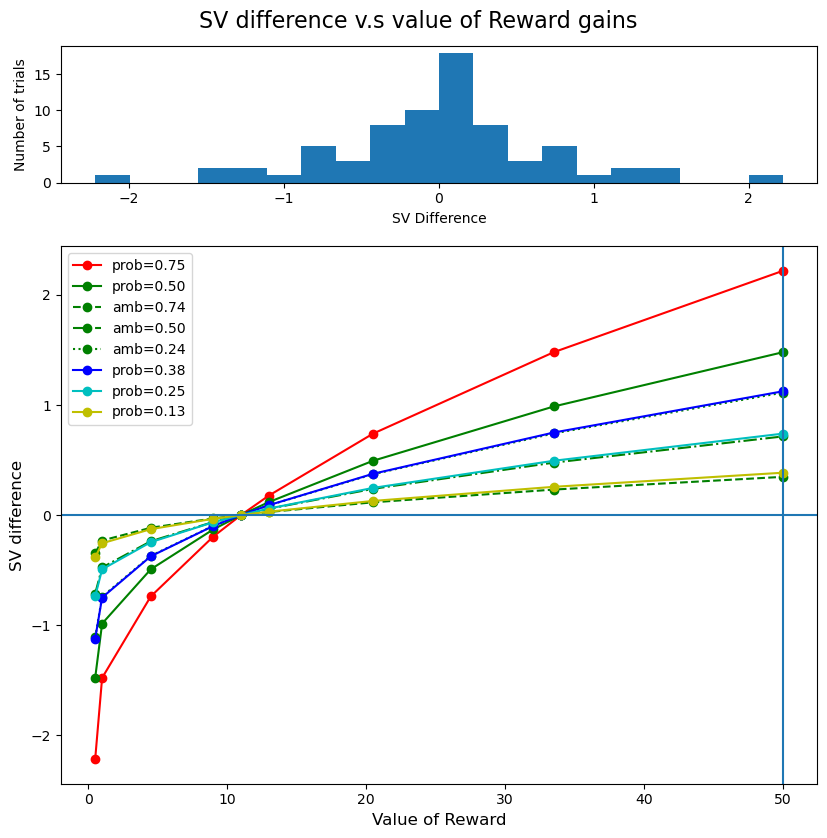

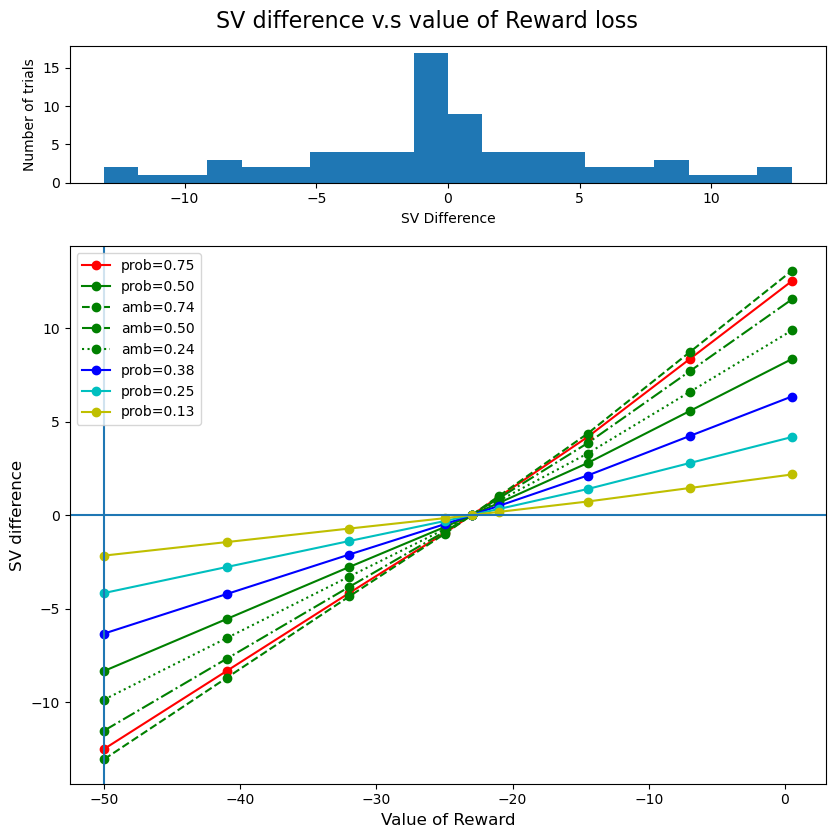

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def scatter_hist(x, y, ax, ax_histy,xlabel='',ylabel='',title=''): #This functions creates a scatter plot with histograms at its sides
	#ax.scatter(x, y)
	ax.set_xlabel(xlabel,fontsize=12) #Creates the subplots
	ax.set_ylabel(ylabel,fontsize=12)
	plt.suptitle(title,fontsize=16, ha='center')
	#ax_histx.hist(x,bins=20)
	ax_histy.hist(y, bins=20)
	ax_histy.set_xlabel('SV Difference')
	ax_histy.set_ylabel('Number of trials')
	plt.tight_layout()


def setup_fig_ax():  #Setting the axis

	fig = plt.figure(figsize=(8.5,8.5))
	gs = GridSpec(4, 3)

	ax = fig.add_subplot(gs[1:4, 0:3])
	ax_histy = fig.add_subplot(gs[0,0:3])
	#ax_histx = fig.add_subplot(gs[1:4, 3])
	#ax_histx.tick_params(axis="x", labelbottom=False)
	ax_histy.tick_params(axis="y")
 	
	#Adjust spacing around subplots
	#plt.subplots_adjust(top=1.4, bottom=0.15, left=0.15, right=0.9)
	
	return ax, ax_histy

def plot_scatter_hist(df,xvline=50,trials='gains'):

	# delta SV v.s value_reward
	df['deltaSV'] = df['SV_reward']-df['SV_safe']
	x,y = df['value_reward'],df['deltaSV'] 
	ax,ax_histy = setup_fig_ax()

	scatter_hist(x,y,ax,ax_histy,  
		xlabel='Value of Reward',
		ylabel= 'SV difference',
		title= 'SV difference v.s value of Reward {}'.format(trials))

	colors = ['r','g','b','c','y','m','k']
	amb_line = ['--','-.',':']
	df = df.sort_values('value_reward')

	for i,p in enumerate(reversed(sorted(df['p_reward'].unique()))): #A scatter plot for each probability level
		df_p = df.loc[(df['p_reward']==p) & (df['ambiguity']==A_null)]
		x,y = df_p['value_reward'],df_p['deltaSV']
		ax.plot(x, y,'{}o-'.format(colors[i]),label='prob={0:0.2f}'.format(p)) #The plot conecting prob levels
		if p==0.50:
			for j,A in enumerate(reversed(sorted(df['ambiguity'].unique()))):
				if A==0:
					continue
				df_A = df.loc[(df['p_reward']==p) & (df['ambiguity']==A)]
				x,y = df_A['value_reward'],df_A['deltaSV']
				ax.plot(x, y,'{0}o{1}'.format(colors[i],amb_line[j]),label='amb={0:0.2f}'.format(A)) #The plot conecting prob levels
				
		

	# ax.plot([50],[],'r-')
	ax.axvline(x=xvline)
	# ax.plot([-50,-50],[-10,10],'r-')
	ax.axhline(y=0)
	# ax.plot([0,50],[0,0],'k--')
	ax.legend(loc="upper left")

plot_scatter_hist(pd.DataFrame.from_dict(trials_gain),xvline=50)
plot_scatter_hist(pd.DataFrame.from_dict(trials_loss),xvline=-50,trials='loss')
